# Section 1.5 Advanced example: Image de-noising
We conclude this chapter with a very useful example, de-noising of images. Image de-noising is the process of removing image noise while at the same time trying to preserve details and structures. We will use the Rudin-Osher-Fatemi de-noising model (ROF) originally introduced in [28]. Removing noise from images is important for many applications, from making your holiday photos look better to improving the qual- ity of satellite images. The ROF model has the interesting property that it finds a smoother version of the image while preserving edges and structures.
The underlying mathematics of the ROF model and the solution techniques are quite advanced and outside the scope of this book. We’ll give a brief (simplified) in- troduction before showing how to implement a ROF solver based on an algorithm by Chambolle [5].

The total variation (TV) of a (grayscale) image $I$ is defined as the sum of the gradient norm. In a continuous representation this is: 
$$J(I)=\int{ |\nabla I | dx} $$
In a discrete setting, the total variation becomes
$$J(I)=\sum_x |\nabla I |  $$
where the sum is taken over all image coordinates $x = [x, y]$.

In the (Chambolle) version of ROF, the goal is to find a de-noised image $U$ that minimizes: $$\min_U ||I-U||^2 + 2\lambda J(U),$$

where the norm $||I-U||$ measures the difference between $U$ and the original image $I$. What this means is in essence that the model looks for images that are "flat" but allow "jumps" at edges between regions.This is similar to a $\chi^2$, where the $\lambda$ term is a regularization.

Here is how to implement this algorithm in python

In [31]:
%matplotlib inline
from pylab import *
from numpy import *

def denoise(im,U_init,tolerance=0.1,tau=0.125,tv_weight=100):
    """ An implementation of the Rudin-Osher-Fatemi (ROF) denoising model
    using the numerical procedure presented in eq (11) A. Chambolle (2005).
    Input: noisy input image (grayscale), initial guess for U,
    weight of the TV-regularizing term, steplength, tolerance for stop criterion.
    Output: denoised and detextured image, texture residual. """ 
    m,n = im.shape #size of noisy image
    # initialize
    U = U_init
    Px = im #x-component to the dual field 
    Py = im #y-component of the dual field
    error = 1
    while (error > tolerance): 
        Uold = U
        # gradient of primal variable
        GradUx = roll(U,-1,axis=1)-U # x-component of U’s 
        GradUy = roll(U,-1,axis=0)-U # y-component of U’s
        # update the dual varible
        PxNew = Px + (tau/tv_weight)*GradUx
        PyNew = Py + (tau/tv_weight)*GradUy
        NormNew = maximum(1,sqrt(PxNew**2+PyNew**2))
        Px = PxNew/NormNew # update of x-component (dual)
        Py = PyNew/NormNew # update of y-component (dual)
        # update the primal variable
        RxPx = roll(Px,1,axis=1) # right x-translation of x-component
        RyPy = roll(Py,1,axis=0) # right y-translation of y-component
        DivP = (Px-RxPx)+(Py-RyPy) # divergence of the dual field. U  = im + tv_weight*DivP # update of the primal variable
        # update of error
        error = linalg.norm(U-Uold)/sqrt(n*m);
    return U,im-U # denoised image and texture residual

In this example, we used the function roll(), which as the name suggests, "rolls" the values of an array cyclically around an axis. This is very convenient for computing neighbor differences, in this case for derivatives. We also used linalg.norm() which measures the difference between two arrays (in this case the image matrices U and Uold ). 

Let’s start with a synthetic example of a noisy image:


In [32]:
from numpy import *
from numpy import random
from scipy.ndimage import filters 
# create synthetic image with noise
im = zeros((500,500))
im[100:400,100:400] = 128
im[200:300,200:300] = 255
im = im + 30*random.standard_normal((500,500))
U,T = denoise(im,im)
G = filters.gaussian_filter(im,10)
# save the result
import scipy.misc
scipy.misc.imsave('synth_rof.pdf',U)
scipy.misc.imsave('synth_gaussian.pdf',G)

(-0.5, 499.5, 499.5, -0.5)

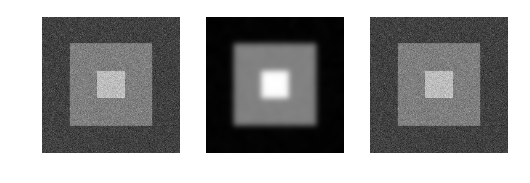

In [33]:
# Now we plot the original, a blurred version,
# and the ROF de-noised image
figure()
gray()
subplot(1,3,1)
imshow(im)
axis('off')
subplot(1,3,2)
imshow(G)
axis('off')
subplot(1,3,3)
imshow(U)
axis('off')

Now, let’s see what happens with a real image:

(-0.5, 568.5, 799.5, -0.5)

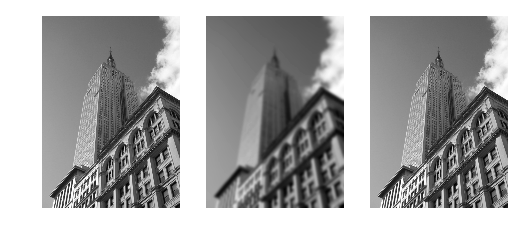

In [40]:
from PIL import Image
from pylab import *
# import rof
im = array(Image.open('empire.jpg').convert('L'))
U,T = denoise(im,im)
G = filters.gaussian_filter(im,5)

figure()
gray()
subplot(1,3,1)
imshow(im)
axis('off')
subplot(1,3,2)
imshow(G)
axis('off')
subplot(1,3,3)
imshow(U)
axis('off')